<a href="https://colab.research.google.com/github/mourodrigo/mourodrigo-data-science-covid-data-br-rs/blob/master/data_science_covid_data_br_rs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download dos dados atualizados do Ministério da Saúde

In [1]:
#@title
import pandas as pd
import sys
from datetime import date, timedelta
import matplotlib.pyplot as plt


In [2]:
#@title Getting fresh data
!wget -O sample_data/covid_rs.csv http://ti.saude.rs.gov.br/covid19/download

rs = pd.read_csv("sample_data/covid_rs.csv", error_bad_lines=False, encoding='cp1252', delimiter = ';')

--2020-07-17 13:23:58--  http://ti.saude.rs.gov.br/covid19/download
Resolving ti.saude.rs.gov.br (ti.saude.rs.gov.br)... 200.198.173.170
Connecting to ti.saude.rs.gov.br (ti.saude.rs.gov.br)|200.198.173.170|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ti.saude.rs.gov.br/covid19/download [following]
--2020-07-17 13:24:00--  https://ti.saude.rs.gov.br/covid19/download
Connecting to ti.saude.rs.gov.br (ti.saude.rs.gov.br)|200.198.173.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘sample_data/covid_rs.csv’

sample_data/covid_r     [               <=>  ]   7.97M  2.46MB/s    in 3.2s    

2020-07-17 13:24:04 (2.46 MB/s) - ‘sample_data/covid_rs.csv’ saved [8361531]



In [3]:
#@title Parsing data

rs['DATA_CONFIRMACAO'] = pd.to_datetime(rs['DATA_CONFIRMACAO'], format='%d/%m/%y')
rs['DATA_SINTOMAS'] = pd.to_datetime(rs['DATA_SINTOMAS'], format='%d/%m/%y')
rs['DATA_EVOLUCAO'] = pd.to_datetime(rs['DATA_EVOLUCAO'], format='%d/%m/%y')
rs['DATA_EVOLUCAO_ESTIMADA'] = pd.to_datetime(rs['DATA_EVOLUCAO_ESTIMADA'], format='%d/%m/%y')

rs['BAIRRO'] = rs['BAIRRO'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

rs = rs.sort_values(by='DATA_CONFIRMACAO', ascending=False)

# Avaliação por região

In [4]:
#@title Filtering cities around me

region = rs[
            (rs['MUNICIPIO']=="PLANALTO")
            | (rs['MUNICIPIO']=="ALPESTRE")
            | (rs['MUNICIPIO']=="AMETISTA DO SUL")
            # | (rs['MUNICIPIO']=="NONOAI")
            # | (rs['MUNICIPIO']=="FREDERICO WESTPHALEN")
            ]
region = region.sort_values(by='DATA_CONFIRMACAO', ascending=False)
region = region.drop(['COD_REGIAO_COVID', 'REGIAO_COVID', 'COD_IBGE'], axis=1)

In [5]:
#@title Preparing data with dummy columns to normalize the city info 
timeline = pd.get_dummies(region, columns=["MUNICIPIO"])

#grouping and summing the dummy data
grouped = timeline.groupby(
     ['DATA_CONFIRMACAO']
).agg(
     cases_planalto = ('MUNICIPIO_PLANALTO','sum'),
     cases_ametista = ('MUNICIPIO_AMETISTA DO SUL','sum'),
     cases_alpestre = ('MUNICIPIO_ALPESTRE','sum'),
    #  cases_frederico = ('MUNICIPIO_FREDERICO WESTPHALEN','sum'),
    #  cases_nonoai = ('MUNICIPIO_NONOAI','sum'),
      
 ).reset_index()

#creating an index to work as the x axys on the chart
grouped = grouped.set_index('DATA_CONFIRMACAO')

**Histórico de casos confirmados na região**

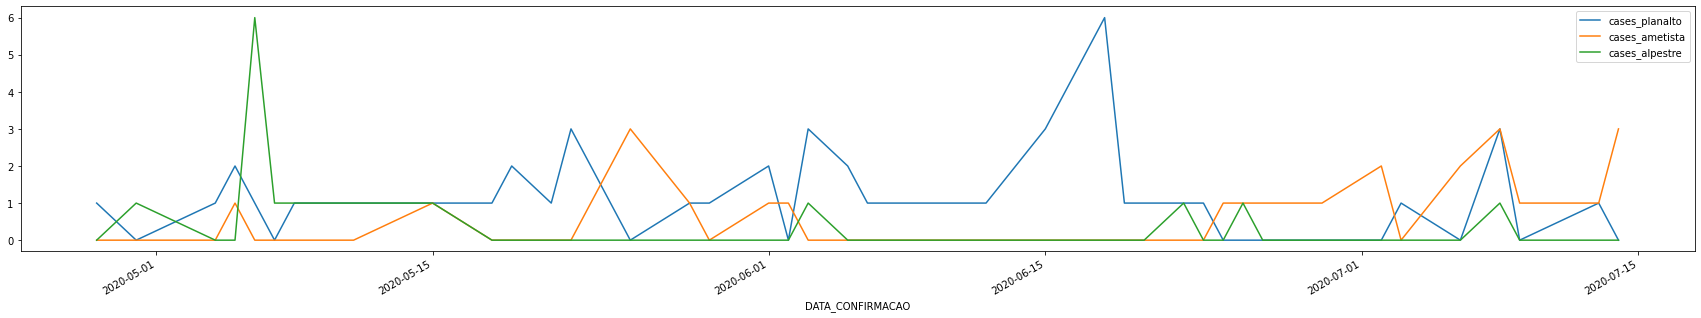

In [6]:
#@title Grafico histórico de casos confirmados nas cidades determinadas
lines = grouped.plot.line(figsize=(30, 5))
lines.legend()

# **Acompanhamento dos ultimos 15 dias da região**

In [7]:
#@title Filtrando dados dos últimos 15 dias
recent_days = (date.today()-timedelta(days=15)).isoformat() # last 15 days
region_recent_cases = region[(region['DATA_CONFIRMACAO'] > recent_days)]

print(region_recent_cases["MUNICIPIO"].count(), "casos confirmados nos ultimos 15 dias")

16 casos confirmados nos ultimos 15 dias


In [8]:
#@title
region_recent_cases

,MUNICIPIO,SEXO,FAIXAETARIA,CRITERIO,DATA_CONFIRMACAO,DATA_SINTOMAS,DATA_EVOLUCAO,EVOLUCAO,HOSPITALIZADO,FEBRE,TOSSE,GARGANTA,DISPNEIA,OUTROS,COMORBIDADES,DATA_INCLUSAO_OBITO,DATA_EVOLUCAO_ESTIMADA,RACA_COR,PROFISSIONAL_SAUDE,BAIRRO,HOSPITALIZACAO_SRAG,FONTE_INFORMACAO
1086,AMETISTA DO SUL,Feminino,40 a 49,TESTE RÁPIDO,2020-07-14,2020-07-05,NaT,EM ACOMPANHAMENTO,NAO,NAO,NAO,NAO,NAO,SIM,NaN,NaN,NaT,AMARELA,NAO,CENTRO,NAO,E-SUS
1104,AMETISTA DO SUL,Masculino,30 a 39,TESTE RÁPIDO,2020-07-14,2020-07-05,NaT,EM ACOMPANHAMENTO,NAO,SIM,NAO,NAO,SIM,SIM,NaN,NaN,NaT,BRANCA,NAO,APARECIDA,NAO,E-SUS
1085,AMETISTA DO SUL,Masculino,20 a 29,TESTE RÁPIDO,2020-07-14,2020-07-07,NaT,EM ACOMPANHAMENTO,NAO,NAO,NAO,SIM,NAO,SIM,NaN,NaN,NaT,BRANCA,NAO,CENTRO,NAO,E-SUS
28262,PLANALTO,Masculino,30 a 39,TESTE RÁPIDO,2020-07-13,2020-07-13,NaT,EM ACOMPANHAMENTO,NAO,NAO,NAO,NAO,NAO,SIM,NaN,NaN,NaT,INDIGENA,NAO,AREA INDIGENA,NAO,E-SUS
1103,AMETISTA DO SUL,Masculino,60 a 69,RT-PCR,2020-07-13,2020-07-01,2020-07-13,RECUPERADO,SIM,NAO,SIM,NAO,SIM,SIM,Outra Pneumatopatia Crônica,NaN,NaT,PARDA,NAO INFORMADO,CENTRO,SIM,SIVEP HOSP
1106,AMETISTA DO SUL,Feminino,40 a 49,Ignorado,2020-07-09,2020-07-08,NaT,EM ACOMPANHAMENTO,NAO,NAO,NAO,NAO,NAO,SIM,NaN,NaN,NaT,BRANCA,NAO,INTERIOR,NAO,E-SUS
1099,AMETISTA DO SUL,Masculino,30 a 39,TESTE RÁPIDO,2020-07-08,2020-06-30,NaT,RECUPERADO,NAO,NAO,SIM,NAO,NAO,SIM,NaN,NaN,2020-07-14,BRANCA,NAO,BAIRRO APARECIDA,NAO,E-SUS
1102,AMETISTA DO SUL,Masculino,20 a 29,TESTE RÁPIDO,2020-07-08,2020-06-28,NaT,RECUPERADO,NAO,SIM,NAO,NAO,NAO,SIM,NaN,NaN,2020-07-12,BRANCA,NAO,APARECIDA,NAO,E-SUS
192,ALPESTRE,Feminino,20 a 29,RT-PCR,2020-07-08,2020-07-06,NaT,EM ACOMPANHAMENTO,NAO,SIM,SIM,SIM,SIM,SIM,NaN,NaN,NaT,BRANCA,NAO,INTERIOR,NAO,E-SUS
28259,PLANALTO,Masculino,40 a 49,TESTE RÁPIDO,2020-07-08,2020-07-08,NaT,EM ACOMPANHAMENTO,NAO,NAO,NAO,NAO,NAO,SIM,NaN,NaN,NaT,INDIGENA,NAO,AREA INDIGENA,NAO,E-SUS


**Estado/evolução dos casos mais recentes**

EVOLUCAO
EM ACOMPANHAMENTO    9
RECUPERADO           7
dtype: int64


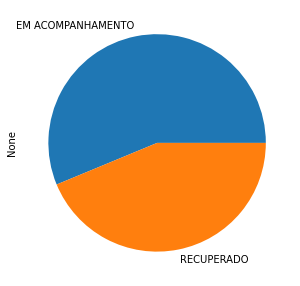

In [9]:
#@title
region_recent_current_status = region_recent_cases.groupby('EVOLUCAO').size()
print(region_recent_current_status)
chart_region_recent_current_status = region_recent_current_status.plot.pie(figsize=(5, 5))


**Cidades dos casos mais recentes**

MUNICIPIO
ALPESTRE            1
AMETISTA DO SUL    10
PLANALTO            5
dtype: int64


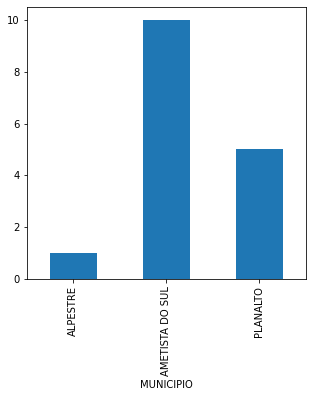

In [10]:
#@title
cities = region_recent_cases.groupby('MUNICIPIO').size()
chart_cities = cities.plot.bar(figsize=(5, 5))
print(cities)



# Avaliação cidade de Planalto - RS

In [11]:
#@title
city = "PLANALTO"

# RECENT CASES
cidade = region_recent_cases[
            (region_recent_cases['MUNICIPIO']==city)
            ]

# ALL CASES
# cidade = rs[
#             (rs['MUNICIPIO']==city)
#             ]

In [12]:
#@title Casos ativos recentes
print(cidade["MUNICIPIO"].count(), "casos ativos em",city,"nos ultimos 15 dias")

5 casos ativos em PLANALTO nos ultimos 15 dias


BAIRRO
AREA INDIGENA    3
CENTRO           2
dtype: int64


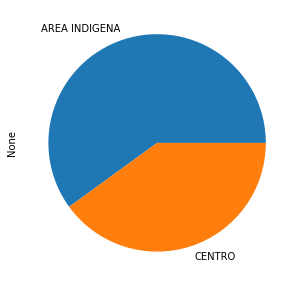

In [13]:
#@title Bairros dos casos recentes
neighborhoods_city = cidade.groupby('BAIRRO').size()
print(neighborhoods_city)

chart_neighborhoods_city = neighborhoods_city.plot.pie(figsize=(5, 5))
chart_neighborhoods_city

FAIXAETARIA
20 a 29    1
30 a 39    3
40 a 49    1
dtype: int64


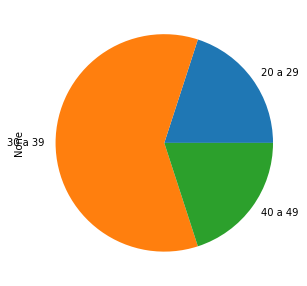

In [14]:
#@title Faixa etária dos casos recentes
age = cidade.groupby('FAIXAETARIA').size()
print(age)

chart_age = age.plot.pie(figsize=(5, 5))
chart_age